# The Ultimate Algo Trader (Neurobot 1.0)

## Introduction:
This jupyter notebook contains code for developing and testing an algorithmic trader based on Python and Machine learning strategy.

## Steps:
1. **Data preperation**: Access historical market data via Alpaca API and preprocess it for analysis.
2. **Strategy**: Develop algorithmic trading strategies and instantiate LSTM model.
3. **Backtesting-Risk/Reward**: Backtest the strategy using historical data and calculate both the risk and the reward metrics
4. **live Trading(Optional)**: Implement the strategy for paper trading on Alpaca via API.

#### Notes: 
- This notebook is for educational and experimental purposes only.

### Imports and Dependencies

In [1]:
import os
import numpy as np
import random
import datetime
import seaborn as sns
import pandas as pd
import yfinance as yf
import hvplot.pandas
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
from scipy.interpolate import interp1d
from alpaca_trade_api.rest import REST, TimeFrame
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error
import pandas_ta as ta
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from finta import TA
import holoviews as hv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


# Initialize python files and import functions
import stock_data as data
import algo_strategy as strategy
import backtesting as test
import feature_list as feature

import warnings
warnings.filterwarnings('ignore')


In [2]:
load_dotenv()

True

In [3]:
# Set API credentials
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
base_url = 'https://paper-api.alpaca.markets'

# ticker list based on monthly highest dollar volume rank(liquidity) 
tickers_list = data.get_top_tickers(sp500_url = os.getenv("SP500_URL"))
tickers = [ticker[1] for ticker in tickers_list]

# Call the function to fetch stock data
stock_data = data.fetch_stock_data(tickers, alpaca_api_key, alpaca_secret_key, base_url)
stock_df = stock_data.dropna()

[*********************100%%**********************]  503 of 503 completed


In [4]:
print(tickers)

['ZTS', 'CHTR', 'CAT', 'CBRE', 'CCI', 'CDNS', 'CDW', 'CE', 'IPG', 'CHD', 'CI', 'ITW', 'CLX', 'IP', 'CMCSA', 'COF', 'COR', 'INCY', 'CRL', 'CTAS', 'IRM', 'BKNG', 'CTVA', 'K', 'AKAM', 'ALGN', 'ALLE', 'AMAT', 'AMCR', 'KDP', 'AME', 'AMGN', 'AMT', 'BIO', 'AMZN', 'APD', 'AWK', 'AZO', 'CNC', 'BAX', 'JBL', 'BDX', 'CTLT', 'CZR', 'NI', 'FTNT', 'F', 'FANG', 'FI', 'HPQ', 'HPE', 'FOXA', 'FRT', 'FSLR', 'GEHC', 'EXPD', 'GEN', 'GNRC', 'HIG', 'HES', 'GPC', 'GPN', 'HD', 'HAS', 'EXPE', 'HSY', 'DE', 'EFX', 'DFS', 'ICE', 'DIS', 'DLR', 'DOC', 'DPZ', 'DUK']


In [5]:
stock_df

,symbol,open,high,low,close,volume
timestamp,,,,,,
2016-03-01 05:00:00+00:00,AKAM,54.37,55.5700,54.0000,55.53,4019353
2016-03-02 05:00:00+00:00,AKAM,55.40,56.3100,55.0401,56.21,2491544
2016-03-03 05:00:00+00:00,AKAM,55.83,55.8920,55.2000,55.64,2595881
2016-03-04 05:00:00+00:00,AKAM,55.65,55.9800,55.0300,55.57,2896694
2016-03-07 05:00:00+00:00,AKAM,55.00,55.9800,54.9200,55.33,3065895
...,...,...,...,...,...,...
2024-02-26 05:00:00+00:00,ZTS,196.90,197.9900,195.4600,197.04,2098518
2024-02-27 05:00:00+00:00,ZTS,197.65,199.2500,194.0400,199.00,1984613
2024-02-28 05:00:00+00:00,ZTS,199.30,200.5000,197.1000,199.94,2003263


#### Feauture Engineering

In [6]:
daily_returns = feature.calculate_pct_change(stock_df)

In [7]:
cumulative_returns = feature.cumulative_returns(stock_df)

In [8]:
sma = feature.simple_moving_averge(stock_df)

In [9]:
sma_ema_long_short = feature.sma_ema_long_short(stock_df)

In [10]:
standard_deviation = feature.standard_deviation(stock_df)

In [11]:
Upper_lower_bollinger = feature.calculate_bollinger_bands(stock_df)

In [12]:
finta = feature.finta_technical_indicators(stock_df)

### Data Processing and Cleaning

In [13]:
# Drop NAN values
stock_df.dropna(inplace=True)
display(stock_df.head())
display(stock_df.tail())


,symbol,open,high,low,close,volume,Daily Returns,Cumulative Returns,SMA20,SMA50,SMA100,STD,Upper Band,Lower Band,TA Short,TA Long
timestamp,,,,,,,,,,,,,,,,
2016-07-21 04:00:00+00:00,AKAM,57.89,58.12,57.010,57.20,1643677,-0.010894,1.030074,55.7570,54.1341,53.78025,1.785344,59.327688,52.186312,56.390000,54.1341
2016-07-22 04:00:00+00:00,AKAM,57.45,58.14,57.240,57.89,1135778,0.012063,1.042500,55.7930,54.2775,53.80385,1.822214,59.437428,52.148572,56.520667,54.2775
2016-07-25 04:00:00+00:00,AKAM,57.83,58.33,57.565,57.90,1726940,0.000173,1.042680,56.0205,54.4131,53.82075,1.784803,59.590105,52.450895,56.680667,54.4131
2016-07-26 04:00:00+00:00,AKAM,58.00,58.47,57.690,58.09,3977322,0.003282,1.046101,56.3670,54.5651,53.84525,1.428691,59.224383,53.509617,56.936667,54.5651
2016-07-27 04:00:00+00:00,AKAM,51.23,51.44,47.800,50.51,19701840,-0.130487,0.909598,56.2400,54.5481,53.79465,1.802942,59.845884,52.634116,56.640000,54.5481


,symbol,open,high,low,close,volume,Daily Returns,Cumulative Returns,SMA20,SMA50,SMA100,STD,Upper Band,Lower Band,TA Short,TA Long
timestamp,,,,,,,,,,,,,,,,
2024-02-26 05:00:00+00:00,ZTS,196.90,197.9900,195.46,197.04,2098518,-0.000862,3.548352,191.7395,193.3292,182.8673,4.676759,201.093019,182.385981,192.307333,193.3292
2024-02-27 05:00:00+00:00,ZTS,197.65,199.2500,194.04,199.00,1984613,0.009947,3.583648,192.0515,193.3610,183.1540,4.948663,201.948826,182.154174,192.896000,193.3610
2024-02-28 05:00:00+00:00,ZTS,199.30,200.5000,197.10,199.94,2003263,0.004724,3.600576,192.4770,193.3580,183.4435,5.249146,202.975293,181.978707,193.149333,193.3580
2024-02-29 05:00:00+00:00,ZTS,200.50,200.5341,198.19,198.33,2849159,-0.008052,3.571583,193.0030,193.3988,183.7068,5.283840,203.570681,182.435319,193.232000,193.3988
2024-03-01 05:00:00+00:00,ZTS,196.00,196.2300,188.49,190.82,3724389,-0.037866,3.436341,193.0870,193.2808,183.8592,5.232299,203.551597,182.622403,192.903333,193.2808


### Algorithim Buy/Sell  Best signal selection

In [14]:
simple_momentum = strategy.simple_momentum(stock_df)
dmac= strategy.dmac_strategy(stock_df)
finta_strategy = strategy.finta_strategy(stock_df)
bollinger_bands = strategy.bollinger_bands_strategy(stock_df)
pairs_trading = strategy.pairs_trading_signals(stock_df, entry_threshold=1.0, exit_threshold=0.5)

In [15]:
signal_one = stock_df['Signal_SM']
signal_two = stock_df['Signal_DMAC']
signal_three = stock_df['Signal_FINTA']
signal_four = stock_df['Signal_BB']
signal_five = stock_df['Signal_PTS']

In [16]:
# Create a list of lists containing signals for each asset
signals = [signal_one, signal_two, signal_three, signal_four, signal_five]

In [17]:
def majority_vote(signals):
    majority_signals = []

    # Iterate over each asset's signals
    for asset_signals in zip(*signals):
        buy_count = sum(1 for signal in asset_signals if signal == 1)
        sell_count = sum(1 for signal in asset_signals if signal == -1)
        
        # Determine the majority vote for the current asset
        if buy_count > sell_count:
            majority_signal = 1  # Buy signal
        elif sell_count > buy_count:
            majority_signal = -1  # Sell signal
        else:
            majority_signal = 0  # Hold signal
        
        # Append the majority signal for the current asset to the list
        majority_signals.append(majority_signal)

    return majority_signals

# Call the majority_vote function with the list of signals
majority_signals = majority_vote(signals)

# Add the majority signals as a new column to the existing stock_df DataFrame
stock_df['majority_signal'] = majority_signals

# Add entry and exit columns for plotting entry and exit points
stock_df['entry'] = stock_df['majority_signal'].apply(lambda x: 1 if x == 1 else 0)
stock_df['exit'] = stock_df['majority_signal'].apply(lambda x: -1 if x == -1 else 0)

# Print the updated stock_df DataFrame
stock_df


,symbol,open,high,low,close,volume,Daily Returns,Cumulative Returns,SMA20,SMA50,...,TA Long,Signal_SM,Signal_DMAC,Signal_FINTA,Signal_BB,Spread,Signal_PTS,majority_signal,entry,exit
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-07-21 04:00:00+00:00,AKAM,57.89,58.1200,57.010,57.20,1643677,-0.010894,1.030074,55.7570,54.1341,...,54.1341,-1.0,0.0,0.0,0.0,-0.69,0,-1,0,-1
2016-07-22 04:00:00+00:00,AKAM,57.45,58.1400,57.240,57.89,1135778,0.012063,1.042500,55.7930,54.2775,...,54.2775,1.0,0.0,0.0,0.0,0.44,0,1,1,0
2016-07-25 04:00:00+00:00,AKAM,57.83,58.3300,57.565,57.90,1726940,0.000173,1.042680,56.0205,54.4131,...,54.4131,1.0,0.0,0.0,0.0,0.07,0,1,1,0
2016-07-26 04:00:00+00:00,AKAM,58.00,58.4700,57.690,58.09,3977322,0.003282,1.046101,56.3670,54.5651,...,54.5651,1.0,0.0,0.0,0.0,0.09,0,1,1,0
2016-07-27 04:00:00+00:00,AKAM,51.23,51.4400,47.800,50.51,19701840,-0.130487,0.909598,56.2400,54.5481,...,54.5481,-1.0,0.0,0.0,1.0,-0.72,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26 05:00:00+00:00,ZTS,196.90,197.9900,195.460,197.04,2098518,-0.000862,3.548352,191.7395,193.3292,...,193.3292,-1.0,1.0,0.0,0.0,0.14,0,0,0,0
2024-02-27 05:00:00+00:00,ZTS,197.65,199.2500,194.040,199.00,1984613,0.009947,3.583648,192.0515,193.3610,...,193.3610,1.0,1.0,0.0,0.0,1.35,1,1,1,0
2024-02-28 05:00:00+00:00,ZTS,199.30,200.5000,197.100,199.94,2003263,0.004724,3.600576,192.4770,193.3580,...,193.3580,1.0,1.0,0.0,0.0,0.64,0,1,1,0


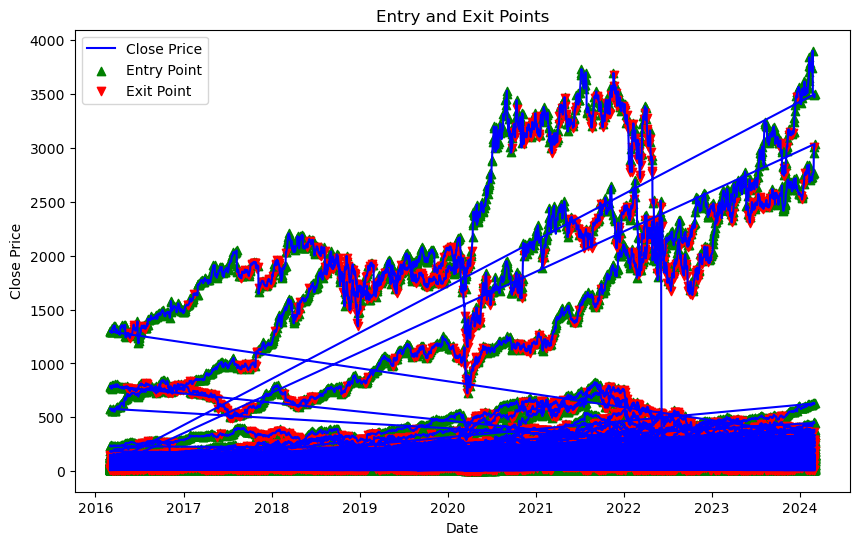

In [18]:
# Plot close price, entry, and exit points
plt.figure(figsize=(10, 6))
plt.plot(stock_df.index, stock_df['close'], label='Close Price', color='b')
plt.scatter(stock_df.index[stock_df['entry'] == 1], stock_df['close'][stock_df['entry'] == 1], marker='^', color='green', label='Entry Point')
plt.scatter(stock_df.index[stock_df['exit'] == -1], stock_df['close'][stock_df['exit'] == -1], marker='v', color='red', label='Exit Point')  # Corrected to use -1 for exit
plt.title('Entry and Exit Points')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()



### Train Test Split

In [19]:
# Define your features (X) and target variable (y)
X = stock_df.drop(columns=["majority_signal","symbol"])
y = stock_df["majority_signal"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### Standardize The Data

In [20]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [21]:
X_train_scaled

array([[-0.12411025, -0.12765753, -0.13074707, ..., -1.59323412,
        -1.39087567, -2.26951977],
       [-0.15862567, -0.15951182, -0.15485975, ..., -0.01200807,
         0.71897152,  0.44062185],
       [-0.28750359, -0.28566687, -0.28496718, ...,  1.56921798,
         0.71897152,  0.44062185],
       ...,
       [-0.3492651 , -0.34975957, -0.34826648, ..., -0.01200807,
         0.71897152,  0.44062185],
       [-0.05491294, -0.05766589, -0.05650022, ..., -0.01200807,
        -1.39087567,  0.44062185],
       [-0.43530394, -0.43574695, -0.435496  , ..., -0.01200807,
         0.71897152,  0.44062185]])

### PCA - dimension reduction

In [22]:
pca = PCA(n_components=3)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled) 


X_train_pca[:5]



array([[-0.42543307, -3.04668416,  0.22681215],
       [-0.56500252,  0.27659288, -1.39466167],
       [-1.00644429,  2.6314166 ,  0.16392224],
       [-0.69227611,  1.40540638,  1.77573969],
       [-0.62303543,  2.22778997, -0.29730423]])

### Machine Learning LSTM Model

In [37]:
# Reshape X_train to include the time step dimension
timesteps = 5

X_train_reshaped = np.array([X_train_pca[i:i+timesteps] for i in range(len(X_train_pca) - timesteps + 1)])
y_train_reshaped = y_train[timesteps - 1:]  # Adjust y_train accordingly

# Reshape X_test to include the time step dimension
X_test_reshaped = np.array([X_test_pca[i:i+timesteps] for i in range(len(X_test_pca) - timesteps + 1)])
y_test_reshaped = y_test[timesteps - 1:]  # Adjust y_test accordingly

print("Shape of X_train_reshaped:", X_train_reshaped.shape)
print("Shape of y_train_reshaped:", y_train_reshaped.shape)
print("Shape of X_test_reshaped:", X_test_reshaped.shape)
print("Shape of y_test_reshaped:", y_test_reshaped.shape)


Shape of X_train_reshaped: (103365, 5, 3)
Shape of y_train_reshaped: (103365,)
Shape of X_test_reshaped: (44297, 5, 3)
Shape of y_test_reshaped: (44297,)


##### Data reshape

In [27]:
#LSTM MODEL

model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    LSTM(units=50, return_sequences=False),
    Dense(units=1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_reshaped, y_train_reshaped, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test_reshaped,))

Epoch 1/10
3231/3231 [==============================] - 42s 11ms/step - loss: -13.6908 - accuracy: 0.8219 - val_loss: -25.7541 - val_accuracy: 0.8369
Epoch 2/10
3231/3231 [==============================] - 33s 10ms/step - loss: -38.6911 - accuracy: 0.8310 - val_loss: -49.7401 - val_accuracy: 0.8382
Epoch 3/10
3231/3231 [==============================] - 32s 10ms/step - loss: -63.3059 - accuracy: 0.8329 - val_loss: -73.9467 - val_accuracy: 0.8384
Epoch 4/10
3231/3231 [==============================] - 40s 12ms/step - loss: -87.6483 - accuracy: 0.8330 - val_loss: -97.5507 - val_accuracy: 0.8340
Epoch 5/10
3231/3231 [==============================] - 33s 10ms/step - loss: -112.4700 - accuracy: 0.8330 - val_loss: -122.4620 - val_accuracy: 0.8363
Epoch 6/10
3231/3231 [==============================] - 29s 9ms/step - loss: -137.3204 - accuracy: 0.8339 - val_loss: -146.4400 - val_accuracy: 0.8367
Epoch 7/10
3231/3231 [==============================] - 40s 12ms/step - loss: -162.0331 - accurac

In [26]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test_reshaped)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# can use stock prices for label, and change metrics and loss to mse

1385/1385 [==============================] - 6s 5ms/step - loss: -245.3621 - accuracy: 0.8385
Test Loss: -245.36207580566406
Test Accuracy: 0.8385443687438965


#### LSTM Prediction

In [38]:
prediction = model.predict(X_test_reshaped)

1385/1385 [==============================] - 6s 4ms/step


In [42]:
# Define the threshold for buy and sell signals
threshold = 0.5

# Create a function to convert predictions into buy and sell signals
def convert_to_signal(prediction, threshold):
    if prediction >= threshold:
        return 1
    else:
        return -1

# Apply the function to each prediction to get the corresponding signal
signals = [convert_to_signal(pred, threshold) for pred in prediction]

# Create a DataFrame to store the signals along with the corresponding predictions
signals_df = pd.DataFrame({"Prediction": prediction.flatten(), "Signal": signals})

# Display the DataFrame
signals_df


,Prediction,Signal
0,1.213921e-10,-1
1,9.734866e-17,-1
2,0.000000e+00,-1
3,1.000000e+00,1
4,1.000000e+00,1
...,...,...
44292,0.000000e+00,-1
44293,9.999996e-01,1
44294,1.000000e+00,1
44295,1.000000e+00,1


In [ ]:
# Merge the predictions DataFrame with the original DataFrame stock_df
#stock_df = pd.concat([stock_df, signals_df], axis=1)

### Backtesting - Trained Model against Test Model 

#### Portfolio-Level Risk/Reward Evaluation Metrics

In [ ]:
portfolio_metric = test.portfolio_metrics(stock_df)
portfolio_metric

In [ ]:
# Calculate trade evaluation inplace
trade_evaluation = test.trade_evaluation(stock_df)
trade_evaluation

### Fundamental Analysis

In [ ]:
stock_df['Cumulative Returns'].plot()

In [ ]:
# Display the report
print(testing_report)

# Visually Compare the Actual and Predicted Returns
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["predicted_signal"] = testing_signal_predictions

predictions_df["actual_returns"] = trading_df["actual_returns"]

predictions_df["trading_algorithm_returns"] = (
    predictions_df["actual_returns"] * predictions_df["predicted_signal"]
)

# Review the DataFrame
predictions_df.head()